In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
import os
if not os.path.exists('/content/A2'):
    os.makedirs('/content/A2')

In [5]:
!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/disease/A2.zip -d /content/A2

In [6]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
!nvidia-smi

Fri May 31 00:23:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   49C    P8              14W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [37]:
batch_size = 64
img_size = 224
model_type = 'A2'

data_dir = '/content/A2'

In [38]:
for folder in os.listdir(data_dir):
    print(folder, len(os.listdir(os.path.join(data_dir, folder))))

normal 50000
disease 50000


In [40]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize
)

# dataset = datasets.ImageFolder(data_dir, ToTensor())

In [12]:
def get_norm_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for inputs, _ in dataset:
        for i in range(3):
            mean[i] += inputs[i,:,:].mean()
            std[i] += inputs[i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))

    return mean, std

In [13]:
# mean_, std_ = get_norm_std(dataset)
# print(mean_, std_)

tensor([0.5620, 0.5327, 0.5136]) tensor([0.1913, 0.1865, 0.1850])


In [43]:
# All dataset
# mean_ = (0.5589, 0.5298, 0.5114)
# std_ = (0.2119, 0.2031, 0.2015)

# imageNet
mean_ = (0.485, 0.456, 0.406)
std_ = (0.229, 0.224, 0.225)

# A2
# mean_ = (0.5620, 0.5327, 0.5136)
# std_ = (0.1913, 0.1865, 0.1850)

In [68]:
transforms = Compose(
        [
            ToTensor(),
            # Normalize(mean_, std_)
        ]
    )

In [69]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [70]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [71]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['disease', 'normal']

In [72]:
print(len(train_dataset), len(valid_dataset))

80000 20000


In [73]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

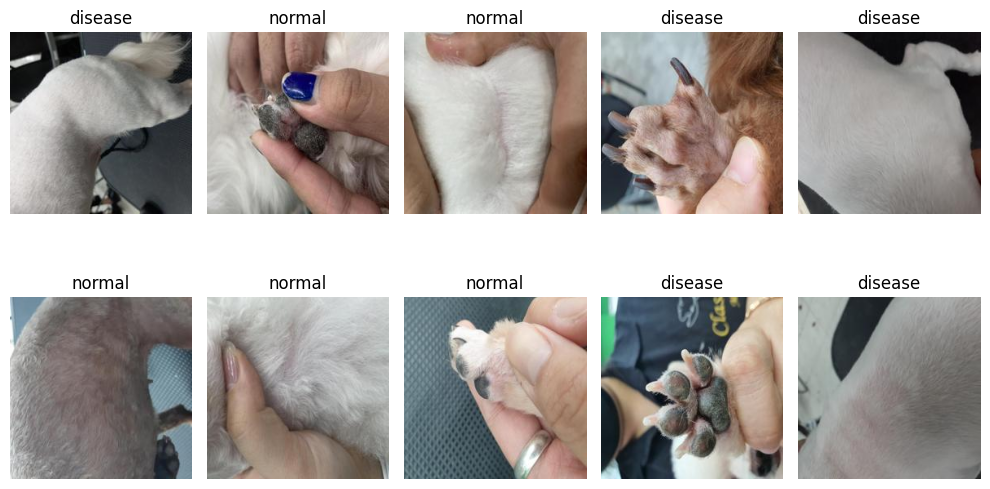

In [74]:
valid_10 = [valid_dataset[i] for i in random.sample(list(range(0, len(valid_dataset))), 10)]

fig, ax = plt.subplots(2, 5, figsize=(10, 6), tight_layout=True)

for i in range(2):
    for j in range(5):
        img = valid_10[(i*5)+j][0]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax[i][j].imshow(img)
        ax[i][j].set_title(labels[valid_10[(i*5)+j][1]])
        ax[i][j].axis('off')

plt.show()

# Model Training

In [ ]:
# inception_v4 1536
# inception_resnet_v2 1536
# resnet50 2048
# resnetv2_50 2048
# efficientnet_b0 1280
# vit_base_patch16_224 768
# vit_base_patch8_224 768
# vit_base_resnet26d_224 768
# vit_base_resnet50d_224 768
# vit_small_resnet26d_224 768
# vit_small_resnet50d_s16_224 768

In [75]:
model_name = 'efficientnet_b0'
hidden_size = 640
pretrained = False
model = timm.create_model(model_name, pretrained=pretrained, num_classes=hidden_size)

In [76]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [77]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [78]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [79]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [80]:
class Classifier(nn.Module):
    def __init__(self, model, hidden_size, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [81]:
classifier = Classifier(model, hidden_size, num_classes=num_classes).to(device)
# classifier = model.to(device)

In [82]:
opt_name = 'AdamW'
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) # correct_bias=False # Adam
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001, weight_decay=0.0005)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                         factor=0.5, patience=2)
loss_fn = nn.CrossEntropyLoss()

In [83]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [84]:
model_path = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [85]:
def load_dict(model, optimizer, lr_scheduler, dict_file):

    pretrained = torch.load(dict_file)

    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']

    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)

    return epoch, labels, model, optimizer, lr_scheduler

In [86]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [87]:
file_path = model_path

pretrained = False

In [88]:
num_epochs = 20

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
lr_epoch = []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}_{opt_name}.pt')
    pkl_file = os.path.join(file_path, f'{model_name}_{opt_name}.pickle')

    epoch_start, labels, model, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']
    best_val_acc, best_val_loss = max(val_acc_epoch), min(val_loss_epoch)

In [89]:
print(epoch_start, best_val_acc, best_val_loss)

0 0.0 100.0


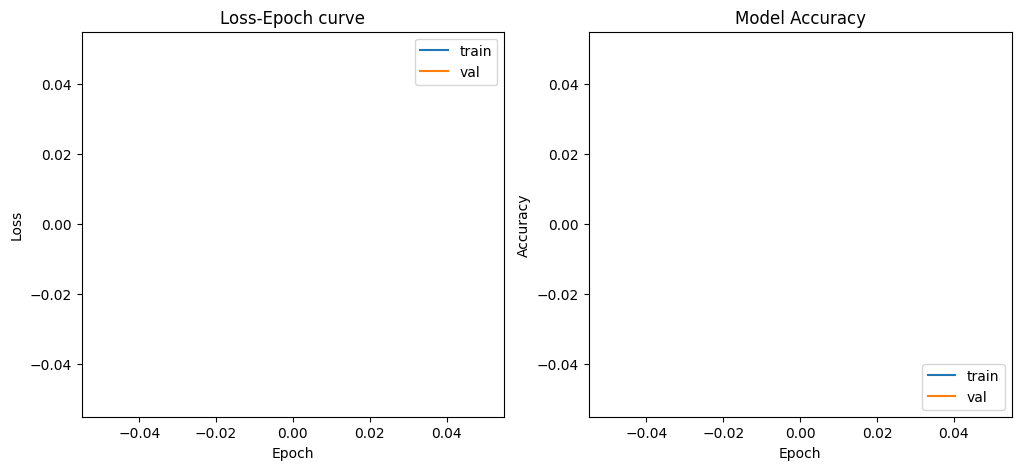

In [90]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [ ]:
epoch_start = e

epoch 7 train acc 0.7342625 validation acc 0.7096645367412141


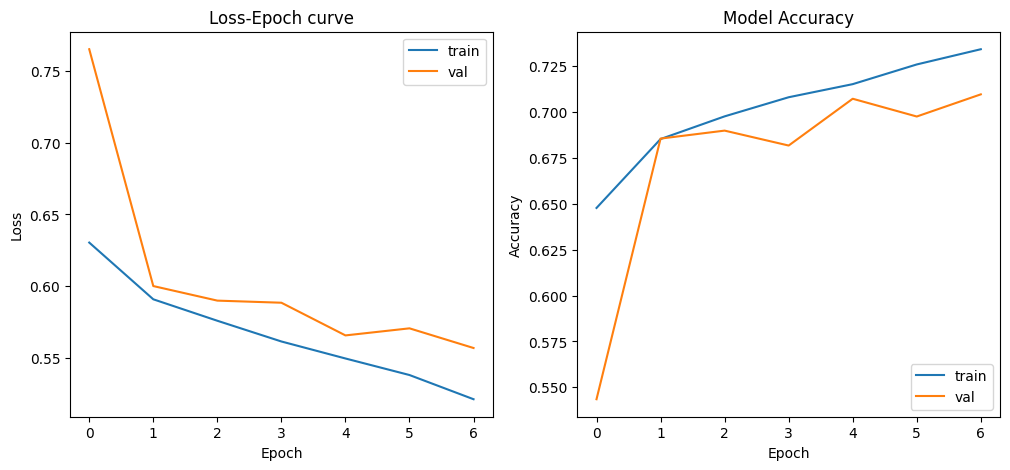

  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 8 train acc 0.7484125 loss 0.5037120924949646 lr 0.001


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 8 valid acc 0.7106629392971247 loss 0.5747355731150594


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 9 train acc 0.765525 loss 0.4797375632047653 lr 0.001


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 9 valid acc 0.6722244408945687 loss 0.6143238556842072


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 10 train acc 0.7860625 loss 0.44906251854896545 lr 0.001


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10 valid acc 0.6903953674121406 loss 0.58673972767382


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 11 train acc 0.8442875 loss 0.35148589438199995 lr 0.0005


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11 valid acc 0.6876497603833865 loss 0.6774985445574069


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 12 train acc 0.880375 loss 0.28121452662348745 lr 0.0005


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12 valid acc 0.6799620607028753 loss 0.7655156947934209


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 13 train acc 0.9090625 loss 0.2216743777126074 lr 0.0005


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13 valid acc 0.6739217252396166 loss 0.9205220157917315


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 14 train acc 0.9509 loss 0.1272843881174922 lr 0.00025


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14 valid acc 0.6697284345047924 loss 1.3334626835375167


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 15 train acc 0.9680625 loss 0.08811349670663476 lr 0.00025


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15 valid acc 0.675569089456869 loss 1.7809120361416484


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 16 train acc 0.9747625 loss 0.0707647801650688 lr 0.00025


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 16 valid acc 0.6701277955271565 loss 2.0655465550696888


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 17 train acc 0.9859375 loss 0.04362752529405989 lr 0.000125


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 17 valid acc 0.6708765974440895 loss 2.570037791904169


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 18 train acc 0.989625 loss 0.03332152212173678 lr 0.000125


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 18 valid acc 0.6700279552715654 loss 2.6919770568323593


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 19 train acc 0.9910375 loss 0.03026532978801988 lr 0.000125


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 19 valid acc 0.6708765974440895 loss 2.5432750683623


  0%|          | 0/1250 [00:00<?, ?it/s]

epoch 20 train acc 0.9941375 loss 0.021493852559570224 lr 6.25e-05


  0%|          | 0/313 [00:00<?, ?it/s]

epoch 20 valid acc 0.6687300319488818 loss 2.9722243227516882


In [91]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr)
    print("epoch {} train acc {} loss {} lr {}".format(e, tot_train_acc, mean_train_loss, lr))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)

    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)

    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, f"{model_name}_{opt_name}")

In [ ]:
save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                model_path, f"{model_name}_{opt_name}_{e}epoch")

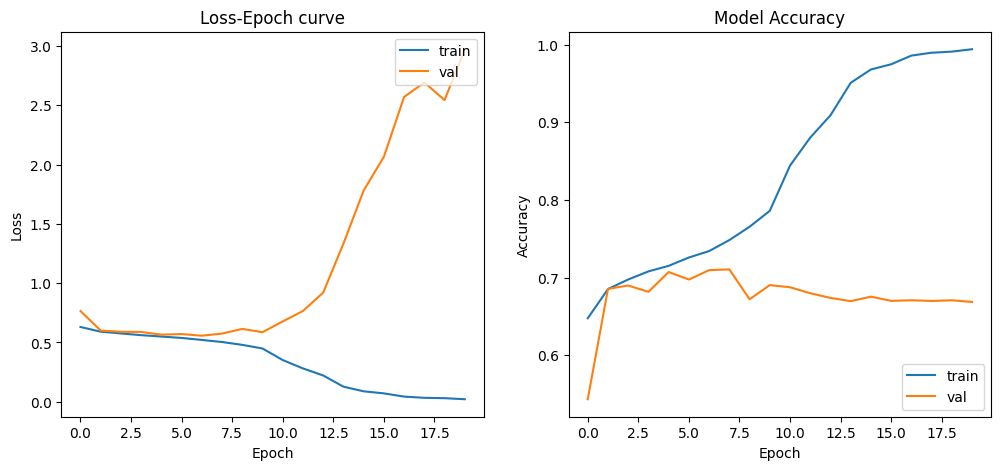

In [92]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

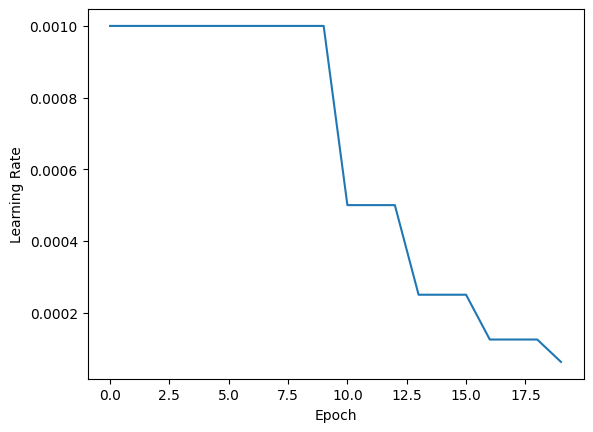

In [93]:
plt.plot(lr_epoch)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# to .onnx

In [ ]:
!pip install onnx

In [ ]:
dict_file = os.path.join(model_path, f'{model_name}_{opt_name}.pt')

pretrained = torch.load(dict_file)

state_dict = pretrained['state_dict']
labels = pretrained['label']

model_dict = classifier.state_dict()
model_dict.update(state_dict)
classifier.load_state_dict(model_dict)

<All keys matched successfully>

In [ ]:
classifier = classifier.to(device)
classifier.eval()

In [ ]:
labels

['무증상', '유증상']

In [ ]:
import torch.onnx

In [ ]:
torch_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(classifier, torch_input, os.path.join(model_path, f'{model_name}_{opt_name}.onnx'))

# Inference

In [ ]:
def inference(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0).to(device)

    outputs = classifier(img)
    result = outputs.softmax(1)
    # result_dict = {}

    # for i, value in enumerate(result[0].tolist()):
    #     result_dict[labels[i]] = value

    # result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return (result[0].argmax(), result[0].tolist())

In [ ]:
if not os.path.exists('/content/A2_test'):
    os.makedirs('/content/A2_test')

!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/disease/test/A2_test.zip -d /content/A2_test

replace /content/A6_test/disease/IMG_D_A6_496645.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
root = '/content/A2_test'

In [ ]:
predictions = {'target':[], 'pred':[], 'probs':[]}
for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))
    for file in os.listdir(os.path.join(root, folder)):
        predictions['target'].append(folder)
        inf_result = inference(os.path.join(root, folder, file))
        predictions['pred'].append(labels[inf_result[0]])
        predictions['probs'].append(inf_result[1])
        if len(predictions['pred']) % 1000 == 0:
            print(len(predictions['pred']), "done")

normal 1605
1000 done
disease 1514
2000 done
3000 done


In [ ]:
import json

with open(f'/content/drive/MyDrive/CV_project/skin_model/prediction/{model_type}_{model_name}_{opt_name}.json', 'w') as f:
    json.dump(predictions, f)

In [ ]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

[Text(0, 0.5, 'disease'), Text(0, 1.5, 'normal')]

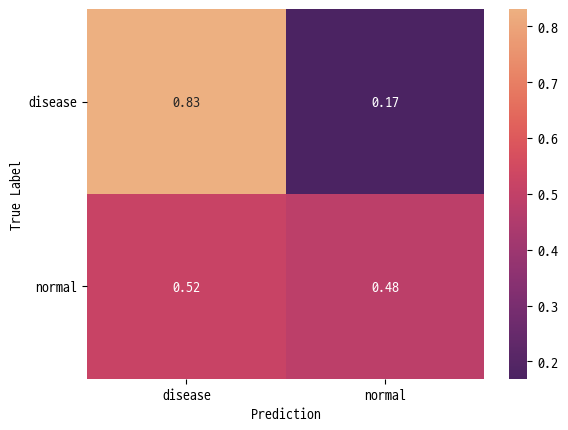

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predictions['target'], predictions['pred'], normalize='true')
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap='flare_r')
hm.set_xlabel('Prediction', fontsize=10)
hm.set_ylabel('True Label', fontsize=10)
hm.set_xticklabels(labels=labels, fontsize=10)
hm.set_yticklabels(labels=labels, fontsize=10, rotation=0)

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(predictions['target'], predictions['pred'])
print(cr)

              precision    recall  f1-score   support

     disease       0.60      0.83      0.70      1514
      normal       0.75      0.48      0.59      1605

    accuracy                           0.65      3119
   macro avg       0.68      0.66      0.64      3119
weighted avg       0.68      0.65      0.64      3119



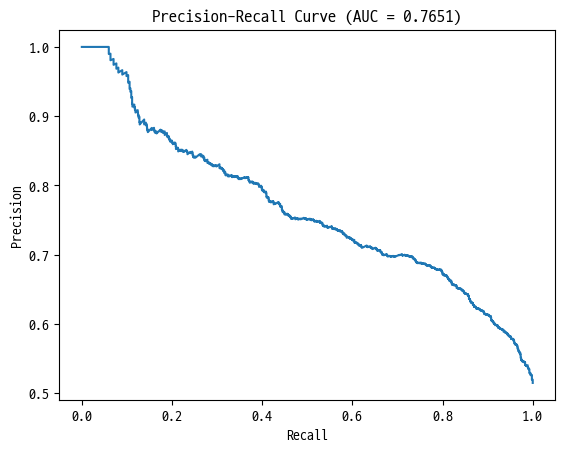

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import numpy as np

target = np.array(predictions['target'])
probs = np.array(predictions['probs'])[:, 1]

precision, recall, thresholds = precision_recall_curve(target, probs, pos_label='normal')
pr_auc = auc(recall, precision)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve (AUC = ' + str(round(pr_auc,4)) + ')')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()